<a href="https://colab.research.google.com/github/neelkanthrawat/GNN-exercises/blob/main/Project/CINN_for_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

from scipy.stats import special_ortho_group
from sklearn.datasets import make_moons, load_digits
import matplotlib.pyplot as plt
import random
import numpy as np
import matplotlib.pyplot as plt
import math

### Dataset for the CINN:

In [2]:
# Function to randomly colorize MNIST dataset with a single color channel
# def random_colorize_rgb_mnist(X):
#     colored_X = np.zeros((X.shape[0], X.shape[1], X.shape[2], 3), dtype=np.uint8)

#     for i in range(X.shape[0]):
#         img = X[i]

#         # Generate random color channel index (0 for red, 1 for green, 2 for blue)
#         color_channel_index = np.random.randint(0, 3)

#         # Set the color based on the selected color channel
#         color = [0, 0, 0]
#         color[color_channel_index] = 255

#         # Colorize the digits while keeping the background unchanged
#         colored_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
#         colored_img[img > 0] = color
#         colored_X[i] = colored_img

#     return colored_X

In [3]:
### Load MNIST training dataset
# train_dataset = MNIST(root='./data', train=True, download=True, transform=ToTensor())
# uncolored_X_train = train_dataset.data.numpy()
# uncolored_y_train = train_dataset.targets.numpy()

# ### Load MNIST test dataset
# test_dataset = MNIST(root='./data', train=False, download=True, transform=ToTensor())
# uncolored_X_test = test_dataset.data.numpy()
# uncolored_y_test = test_dataset.targets.numpy()


# colored_rgb_X_train = random_colorize_rgb_mnist(uncolored_X_train)
# colored_rgb_X_test = random_colorize_rgb_mnist(uncolored_X_test)

# ### labels for the dataset
# # Create labels for uncolored datasets
# uncolored_labels_train = np.zeros(len(uncolored_X_train))
# uncolored_labels_test = np.zeros(len(uncolored_X_test))

# # Create labels for colored datasets
# colored_labels_train = np.ones(len(colored_rgb_X_train))
# colored_labels_test = np.ones(len(colored_rgb_X_test))

In [4]:
# Reshape uncolored images to (60000, 28, 28, 1)
# uncolored_X_train_resized = uncolored_X_train.reshape(-1, 28, 28, 1)
# uncolored_X_test_resized = uncolored_X_test.reshape(-1, 28, 28, 1)

# # Expand single channel to three channels
# uncolored_X_train_expanded = np.repeat(uncolored_X_train_resized, 3, axis=-1)
# uncolored_X_test_expanded = np.repeat(uncolored_X_test_resized, 3, axis=-1)

In [5]:
# Normalize the datasets
# # Convert the datasets to float32 before normalization
# uncolored_X_train_expanded = uncolored_X_train_expanded.astype(np.float32)
# uncolored_X_test_expanded = uncolored_X_test_expanded.astype(np.float32)
# colored_rgb_X_train = colored_rgb_X_train.astype(np.float32)
# colored_rgb_X_test = colored_rgb_X_test.astype(np.float32)

# # # Normalize the datasets
# uncolored_X_train_expanded=uncolored_X_train_expanded/255.0
# uncolored_X_test_expanded = uncolored_X_test_expanded/255.0
# colored_rgb_X_train= colored_rgb_X_train/255.0
# colored_rgb_X_test=colored_rgb_X_test/255.0

In [6]:
# mixed_X_train = np.concatenate((uncolored_X_train_expanded[:len(uncolored_X_train_expanded)],
#                                 colored_rgb_X_train), axis=0)

# mixed_X_test = np.concatenate((uncolored_X_test_expanded[:len(uncolored_X_test_expanded)],
#                                 colored_rgb_X_test), axis=0)

# np.shape(mixed_X_train), np.shape(mixed_X_test)

In [7]:
# mixed_X_train_tensor = torch.tensor(mixed_X_train)
# mixed_X_test_tensor = torch.tensor(mixed_X_test)
# # Permute the mixed_X_train and mixed_X_test tensors
# mixed_X_train_tensor = mixed_X_train_tensor.permute(0, 3, 1, 2)  # earlier channels are the last dimension
# mixed_X_test_tensor = mixed_X_test_tensor.permute(0, 3, 1, 2)  # earlier channels are the last dimension


In [8]:
# torch.save(mixed_X_train_tensor, "images_train_set.pt")
# torch.save(mixed_X_test_tensor, "images_test_set.pt" )

### Let's now load the saved AE model and begin creating the dataset for the CINN training:

In [9]:
class Autoencoder_simpler(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(Autoencoder_simpler, self).__init__()

        self.dropout_prob = dropout_prob

        # Encoder layers
        self.encoder_conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)  # Use stride 2 for downscaling
        self.encoder_conv2 = nn.Conv2d(16, 24, kernel_size=3, stride=2, padding=1)  # Use stride 2 for downscaling
        self.encoder_linear = nn.Linear(24 * 7 * 7, 24)  # 64*6 ---> 20

        # Dropout layers
        self.dropout = nn.Dropout(p=self.dropout_prob)  # Add dropout layer

        # Decoder layers
        self.decoder_linear = nn.Linear(24, 24* 7 * 7)
        self.decoder_conv1 = nn.ConvTranspose2d(24, 16, kernel_size=3, stride=2, padding=1, output_padding=1)  # Use stride 2 for upscaling
        self.decoder_conv2 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1)  # Use stride 2 for upscaling

    def encoder(self, x):
    # Encoder
        x = self.encoder_conv1(x)
        #print("After encoder_conv1:", x.shape)
        x = torch.relu(x)
        #print("After relu:", x.shape)
        x = self.dropout(x)  # Apply dropout
        #print("After dropout:", x.shape)
        x = self.encoder_conv2(x)
        #print("After encoder_conv2:", x.shape)
        x = torch.relu(x)
        #print("After relu:", x.shape)
        x = self.dropout(x)  # Apply dropout
        #print("After dropout:", x.shape)
        x = x.reshape(-1, 24 * 7 * 7)  # Use .reshape() instead of .view()
        #print("After reshaping:", x.shape)
        x = self.encoder_linear(x)
        #print("After encoder_linear:", x.shape)
        return x

    def decoder(self, x):
        # Decoder
        x = self.decoder_linear(x)
        x = x.view(-1, 24, 7, 7)
        x = self.decoder_conv1(x)
        x = torch.relu(x)
        x = self.dropout(x)  # Apply dropout
        x = self.decoder_conv2(x)
        x = torch.relu(x)
        x = torch.clamp(x, 0, 1) # Clamp output
        return x

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [10]:
# Define the path to the pretrained model
checkpoint_path = "/content/autoencoder_mixed_mnist_dropout_0.01_60_epochs.pth"

# Load the pretrained model
pretrained_model_list = torch.load(checkpoint_path,map_location=torch.device('cpu'))

ae_model=Autoencoder_simpler(dropout_prob=0.01)

ae_model.load_state_dict(pretrained_model_list)

<All keys matched successfully>

In [11]:
# ae_model.eval()
# images_test_set=ae_model.encoder(mixed_X_test_tensor)
# images_train_set= ae_model.encoder(mixed_X_train_tensor)

In [12]:
# images_test_set.size(), images_train_set.size()

In [13]:
# torch.save(images_train_set, "encoded_images_train_set.pt")

In [14]:
# torch.save(images_test_set, "encoded_images_test_set.pt")

### Let's load the dataset here:

In [15]:
encoded_image_train_set=torch.load("/content/encoded_images_train_set.pt")
encoded_image_test_set= torch.load("/content/encoded_images_test_set.pt")

In [16]:
encoded_image_train_set.size(), encoded_image_test_set.size()

(torch.Size([120000, 24]), torch.Size([20000, 24]))

In [17]:
### 0 for uncolored and 1 for colored
len_train=encoded_image_train_set.size()[0]
len_test=encoded_image_test_set.size()[0]

labels_train= torch.cat((torch.zeros(len_train // 2),torch.ones(len_train // 2)))
labels_test = torch.cat((torch.zeros(len_test // 2),torch.ones(len_test // 2)))

In [18]:
encoded_image_train_set.size(), labels_train.size(), encoded_image_test_set.size(), labels_test.size()

(torch.Size([120000, 24]),
 torch.Size([120000]),
 torch.Size([20000, 24]),
 torch.Size([20000]))

shuffled data

In [19]:
# # Define the random seed for reproducibility
# torch.manual_seed(42)

# # Generate shuffled indices
# shuffled_indices_train = torch.randperm(encoded_image_train_set.size(0))
# shuffled_indices_test = torch.randperm(encoded_image_test_set.size(0))

# # Shuffle the data and labels using the shuffled indices
# shuffled_encoded_image_train_set = encoded_image_train_set[shuffled_indices_train]
# shuffled_labels_train = labels_train[shuffled_indices_train]

# shuffled_encoded_image_test_set = encoded_image_test_set[shuffled_indices_test]
# shuffled_labels_test = labels_test[shuffled_indices_test]

In [20]:
# shuffled_indices_train[:6], shuffled_labels_train[:6]

### Creating the dataloader

In [21]:
import torch
from torch.utils.data import Dataset

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.color_labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.color_labels[idx]

# Create custom datasets for train and test
train_dataset = CustomDataset(encoded_image_train_set, labels_train)
test_dataset = CustomDataset(encoded_image_test_set, labels_test)

batch_size=64

# Create data loaders with shuffling and fixed random seed
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=np.random.seed)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
# Get the first batch of the train_loader
first_batch = next(iter(train_loader))

# Extract data and labels from the first batch
data, labels = first_batch

# Print the size of the first batch
print("Data Shape:", data.shape)
print("Labels:", labels)


Data Shape: torch.Size([64, 24])
Labels: tensor([0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0.,
        0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
        1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0.])


### CINN code:

In [ ]:
def subnet_constructor(input_size, hidden_size, output_size):
    model = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, output_size)
    )
    return model

def ortogonal_matrix(dim):
    """
    A = torch.normal(mean=torch.zeros((dim,dim)), std=torch.ones((dim,dim)))
    Q, _ = torch.linalg.qr(A)
    if dim == 2:
        Q[1,1] = -Q[0,0]
        Q[0,1] = -Q[1,0]
        print(torch.linalg.det(Q))
    return Q
    """
    Q = special_ortho_group.rvs(dim)
    return torch.Tensor(Q)



In [ ]:
class conditional_coupling_block(nn.Module):
    def __init__(self, input_size, hidden_size, condition_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.condition_size = condition_size
        self.split1 = math.floor(self.input_size/2)
        self.split2 = self.input_size - self.split1
        self.subnet = subnet_constructor(self.split1 + self.condition_size, self.hidden_size, 2*self.split2)

    def forward(self, x, cond, rev=False):
        x1, x2 = x[..., :self.split1], x[..., self.split1:]
        params = self.subnet(torch.cat([x1, cond], -1))
        s, t = params[...,:self.split2], params[...,self.split2:]
        s = torch.tanh(s)
        ljd = torch.sum(s, -1)

        if not rev:
            s = torch.exp(s)
            x2 = s*x2 + t
            return torch.cat([x1,x2], -1), ljd

        if rev:
            s = torch.exp(-s)
            x2 = s * (x2-t)
            return torch.cat([x1,x2], -1)



In [ ]:
class conditional_realNVP(nn.Module):
    def __init__(self, input_size, hidden_size, n_blocks, condition_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_blocks = n_blocks
        self.condition_size = condition_size

        self.coupling_blocks = nn.ModuleList([conditional_coupling_block(input_size, hidden_size, self.condition_size) for _ in range(n_blocks)])
        self.orthogonal_matrices = [ortogonal_matrix(input_size) for _ in range(n_blocks-1)]

    def forward(self, x, cond, rev=False):
        if rev:
            return self._inverse(x, cond)
        return self._forward(x, cond)

    def _forward(self, x, cond):
        cond = nn.functional.one_hot(cond.to(torch.int64), num_classes=self.condition_size)
        ljd = torch.zeros((x.shape[0]))
        for l in range(self.n_blocks-1):
            x, partial_ljd = self.coupling_blocks[l](x, cond)
            ljd += partial_ljd
            x = torch.matmul(x, self.orthogonal_matrices[l])
        x, partial_ljd = self.coupling_blocks[-1](x, cond)
        ljd += partial_ljd
        return x, ljd

    def _inverse(self, x, cond):
        cond = nn.functional.one_hot(cond.to(torch.int64), num_classes=self.condition_size)
        for l in range(self.n_blocks-1, 0, -1):
            x = self.coupling_blocks[l](x, cond, rev=True)
            x = torch.matmul(x, self.orthogonal_matrices[l-1].T)
        x = self.coupling_blocks[0](x, cond, rev=True)
        return x

    def sample(self, num_samples, cond=None):
        samples = []
        if cond is None:
            for c in range(self.condition_size):
                z = torch.normal(mean=torch.zeros((num_samples, self.input_size)), std=torch.ones((num_samples, self.input_size)))
                samples.append(self._inverse(z, cond=c*torch.ones(num_samples)))
        else:
            z = torch.normal(mean=torch.zeros((num_samples, self.input_size)), std=torch.ones((num_samples, self.input_size)))
            samples.append(self._inverse(z, cond=cond*torch.ones(num_samples)))
        return torch.cat(samples, 0)


In [ ]:
def mmd_inverse_multi_quadratic(x, y, bandwidths=None):
    batch_size = x.size()[0]

    # compute the kernel matrices for each combination of x, y
    # (cleverly using broadcasting to do this efficiently)
    xx, yy, xy = torch.mm(x,x.t()), torch.mm(y,y.t()), torch.mm(x,y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    # compute the sum of kernels at different bandwidths
    K, L, P = 0, 0, 0
    if bandwidths is None:
        bandwidths = [0.4, 0.8, 1.6]
    for sigma in bandwidths:
        s = 1.0 / sigma**2
        K += 1.0 / (1.0 + s * (rx.t() + rx - 2.0*xx))
        L += 1.0 / (1.0 + s * (ry.t() + ry - 2.0*yy))
        P += 1.0 / (1.0 + s * (rx.t() + ry - 2.0*xy))

    beta = 1./(batch_size*(batch_size-1)*len(bandwidths))
    gamma = 2./(batch_size**2 * len(bandwidths))

    return beta * (torch.sum(K)+torch.sum(L)) - gamma * torch.sum(P)

In [ ]:
def train_cinn_moons(model, batchsize=1000, epochs=1000, lr=0.001):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        x_data, y_data = make_moons(n_samples=batchsize, shuffle=True, noise=0.1, random_state=42)
        x_data, y_data = torch.Tensor(x_data), torch.Tensor(y_data)
        z, ljd = model(x_data, y_data)
        loss = torch.sum(0.5*torch.sum(z**2, -1)-ljd) / batchsize
        loss.backward()
        optimizer.step()
        if (epoch+1) % (epochs//3) == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


In [ ]:
x_data, y_data = make_moons(n_samples=5, shuffle=True, noise=0.1, random_state=42)
x_data, y_data = torch.Tensor(x_data), torch.Tensor(y_data)
y_data.size(), x_data.size()# y data is the sample :)

(torch.Size([5]), torch.Size([5, 2]))

The only major change we need to do in this code:

1. Replace x_data (data from domain 1) and y_data (dataset: condition vectors) with our data and condition respectively.

2. Some changes in the `_forward` function in line number 18 in `conditional_real_nvp` class.

In [ ]:
cINN_moons = conditional_realNVP(2, 64, 10, 2)
train_cinn_moons(cINN_moons, epochs=100)



Epoch [33/100], Loss: -0.9069
Epoch [66/100], Loss: -1.3682
Epoch [99/100], Loss: -1.5442


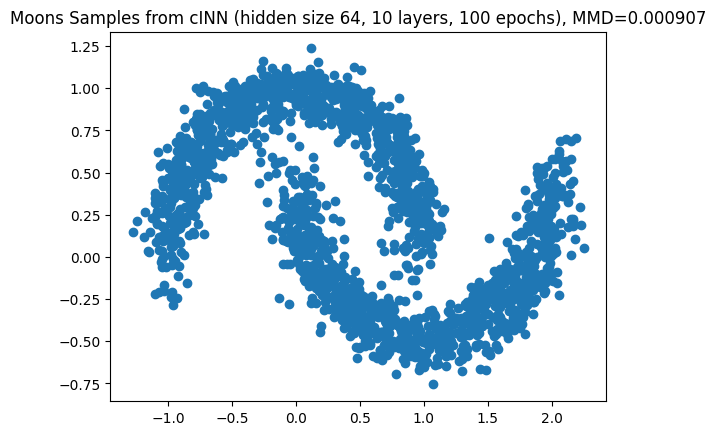

In [ ]:
moons_samples = cINN_moons.sample(1000)
true_moons_data, _ = make_moons(n_samples=2000, shuffle=True, noise=0.1, random_state=42)
true_moons_data = torch.Tensor(true_moons_data)
plt.scatter(moons_samples[:,0].detach().numpy(), moons_samples[:,1].detach().numpy())
mmd_score = mmd_inverse_multi_quadratic(moons_samples, true_moons_data)
plt.title(f"Moons Samples from cINN (hidden size 64, 10 layers, 100 epochs), MMD={mmd_score:.6f}")
plt.show()

### Tasks to do:

0. create the training,val and test datasets for the task style transfer with cINN.
1. Define a different and more general train_and_evaluate function before calling the model function